In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
#X_lin, y_lin = make_regression(2000, n_features=10, n_informative=10, bias=1.0, noise=0.0)

N = 2000
d = 4

X_aux = np.random.randn(N,)

# Make the data nonlinear
X = np.zeros((N,d))

for n in range(d):
    a = np.random.rand(1)
    b = np.random.rand(1)
    c = np.random.rand(1)
    exp = np.round(2*np.random.rand(1) + 1)
    ruido = 0.1*np.random.randn(1)

    X[:,n] =  a + b*X_aux + c*(X_aux**exp) + ruido*np.random.randn(N,)
   

In [4]:
Xtr, Xts, ytr, yts = train_test_split(X, X, test_size=0.5)

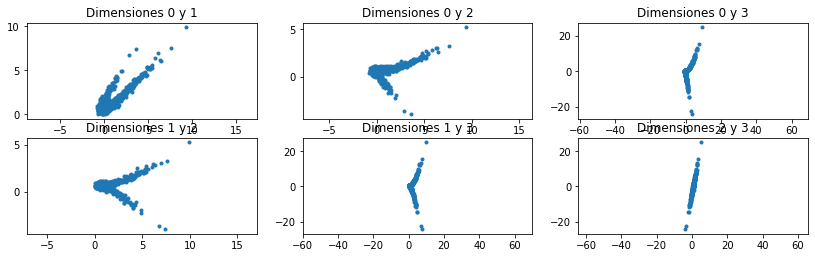

In [5]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xtr[:,n1],Xtr[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        ii += 1

In [14]:
# Define the DRR model class
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.kernel_ridge import KernelRidge

class DRR(BaseEstimator, TransformerMixin):
   
    def __init__(self,estimator_type="Poly"):
        # regressor
        if estimator_type=="Poly":        
            self.parameters = {'polynomialfeatures__degree':np.arange(1,7), 'ridge__alpha':[0.01,0.1,1,10]}
            self.model = make_pipeline(PolynomialFeatures(), Ridge())
        elif estimator_type=="KRR":        
            self.parameters = {'kernel':('linear', 'rbf'), "alpha": [1e0, 0.1, 1e-2, 1e-3],"gamma": np.logspace(-2, 2, 5)}
            self.model = KernelRidge()


    def fit_transform(self,X):
        # PCA
        self.m = np.mean(X, axis = 0)
        Xm = X - self.m[np.newaxis,:]
        cov_matrix = np.dot(Xm.T, Xm) / Xm.shape[0]
        evals, evecs = np.linalg.eigh(cov_matrix)   
        #ordenamos
        idx = np.argsort(-evals)
        self.evecs = evecs[:,idx]
        evals = evals[idx]
        #aplicamos
        Xpca = np.dot(Xm,self.evecs)

        # DRR
        Xdrr = Xpca.copy()

        self.models = []

        for n in np.arange(X.shape[1]-1,0,-1):
            
            clf = GridSearchCV(self.model, self.parameters)
            clf.fit(Xpca[:,0:n], Xpca[:,n])
            x_hat = clf.predict(Xpca[:,0:n])

            Xdrr[:,n] = Xpca[:,n]-x_hat
            self.models.append(clf)
            print(n)

        # DN
        Xdn = Xdrr.copy()

        self.models_dn = []

        for n in np.arange(X.shape[1]-1,0,-1):
            
            clf = GridSearchCV(self.model, self.parameters)
            clf.fit(abs(Xdrr[:,0:n]), Xdrr[:,n])
            x_hat = clf.predict(Xdrr[:,0:n])

            Xdn[:,n] = Xdrr[:,n]/x_hat
            self.models_dn.append(clf)
            print(n)


        return Xdn, Xdrr, Xpca

    def transform(self,X):
        # PCA
        Xm = X - self.m[np.newaxis,:]
        #aplicamos
        Xpca = np.dot(Xm,self.evecs)

        # DRR
        Xdrr = Xpca.copy()

        for n in np.arange(X.shape[1]-1,0,-1):
            ind_m = X.shape[1]-n-1
            x_hat = self.models[ind_m].predict(Xpca[:,0:n])
            Xdrr[:,n] = Xpca[:,n]-x_hat
            print(n)


        # DN
        beta = 0.1
        Xdn = Xdrr.copy()

        for n in np.arange(X.shape[1]-1,0,-1):
            
            ind_m = X.shape[1]-n-1
            x_hat = self.modles_dn[ind_m].predict(Xdrr[:,0:n])

            Xdn[:,n] = Xdrr[:,n]/(x_hat+beta)
            self.models_dn.append(clf)
            print(n)

        return Xdn, Xdrr, Xpca  

    def transform_pca(self,X):
        # PCA
        Xm = X - self.m[np.newaxis,:]
        #aplicamos
        Xpca = np.dot(Xm,self.evecs)    

        return Xpca

    def inverse(self,Xdrr):
        inv_Xdrr = Xdrr.copy()
        for n in np.arange(Xdrr.shape[1]-2,-1,-1):
            x_hat = self.models[n].predict(inv_Xdrr[:,0:Xdrr.shape[1]-n-1])
            inv_Xdrr[:,Xdrr.shape[1]-n-1] = inv_Xdrr[:,Xdrr.shape[1]-n-1] + x_hat
            print(n)  
        # PCA inv
        Xm_inv = np.dot(inv_Xdrr,self.evecs.T)
        X_inv = Xm_inv + self.m[np.newaxis,:]

        return X_inv

    def inverse_pca(self,Xpca):
        inv_Xpca = Xpca.copy()
        # PCA inv
        Xm_inv = np.dot(inv_Xpca,self.evecs.T)
        X_inv = Xm_inv + self.m[np.newaxis,:]

        return X_inv

In [15]:
DRR_model = DRR(estimator_type="KRR")

In [16]:
Xdn_tr, Xdrr_tr, Xpca_tr = DRR_model.fit_transform(Xtr)

3
2
1
3
2
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xdrr_tr[:,n1],Xdrr_tr[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        ii += 1

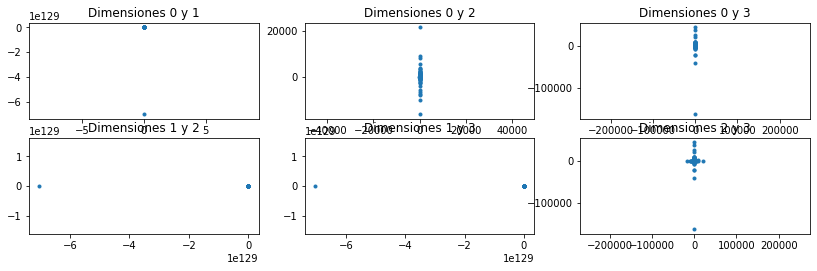

In [13]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xdn_tr[:,n1],Xdn_tr[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        ii += 1

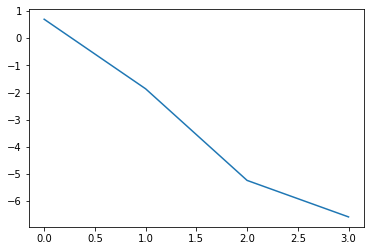

In [ ]:
plt.figure
plt.plot(np.log(np.var(Xdrr_tr,axis=0)))

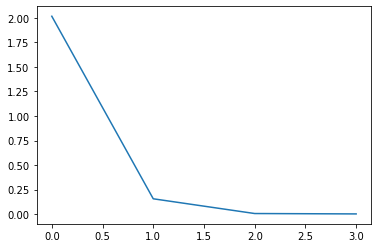

In [ ]:
plt.figure
plt.plot((np.var(Xdrr_tr,axis=0)))

### APPLY

In [ ]:
Xdrr_ts = DRR_model.transform(Xts)

3
2
1


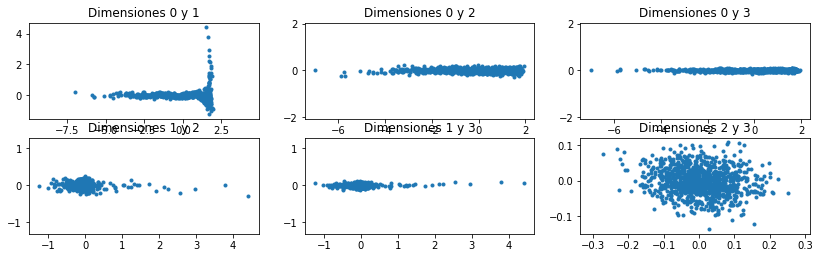

In [ ]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xdrr_ts[:,n1],Xdrr_ts[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        ii += 1

### INVERSE

In [ ]:
inv_Xdrr_ts = DRR_model.inverse(Xdrr_ts)

2
1
0


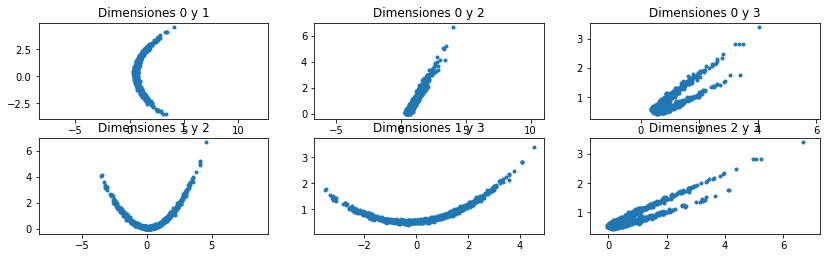

In [ ]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(inv_Xdrr_ts[:,n1],inv_Xdrr_ts[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        ii += 1

([<matplotlib.lines.Line2D at 0x7f17e70acc18>],
 Text(0.5, 1.0, 'Dimensiones 1 y 2'),
 (-1.4599432773820809e-15,
  1.3489209749195652e-15,
  -2.4646951146678474e-15,
  2.90878432451791e-15))

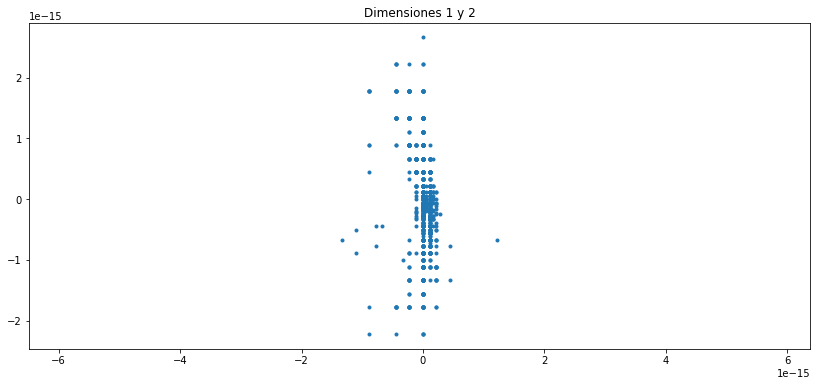

In [ ]:
diff = inv_Xdrr_ts-Xts

# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
plt.plot(diff[:,0],diff[:,1],'.'), plt.title('Dimensiones 1 y 2'), plt.axis('equal')

# DIM REDUCTION

In [ ]:
Nf = 1
red_Xdrr_ts = Xdrr_ts.copy()
red_Xdrr_ts[:,Nf:] = 0
inv_red_Xdrr_ts = DRR_model.inverse(red_Xdrr_ts)

2
1
0


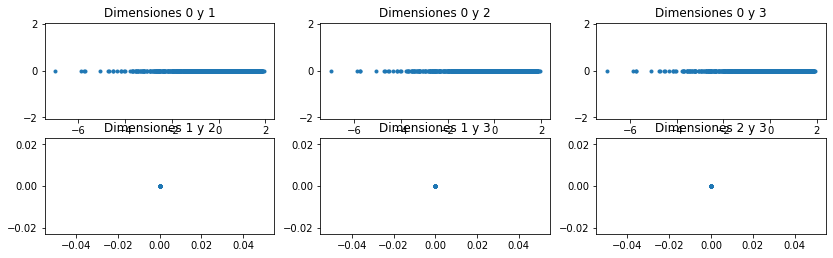

In [ ]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(red_Xdrr_ts[:,n1],red_Xdrr_ts[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        ii += 1

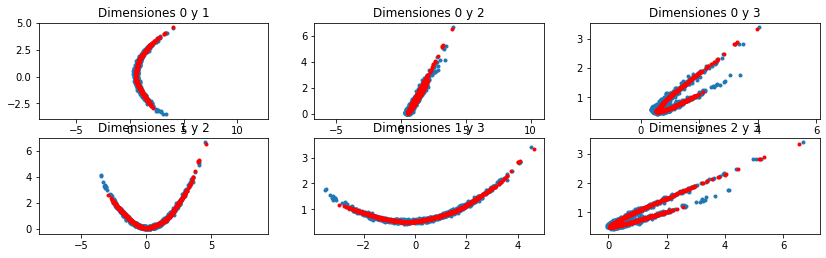

In [ ]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xts[:,n1],Xts[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        plt.plot(inv_red_Xdrr_ts[:,n1],inv_red_Xdrr_ts[:,n2],'r.')
        ii += 1

In [ ]:
Nf = 1
red_Xdrr_tr = Xdrr_tr.copy()
red_Xdrr_tr[:,Nf:] = 0
inv_red_Xdrr_tr = DRR_model.inverse(red_Xdrr_tr)

2
1
0


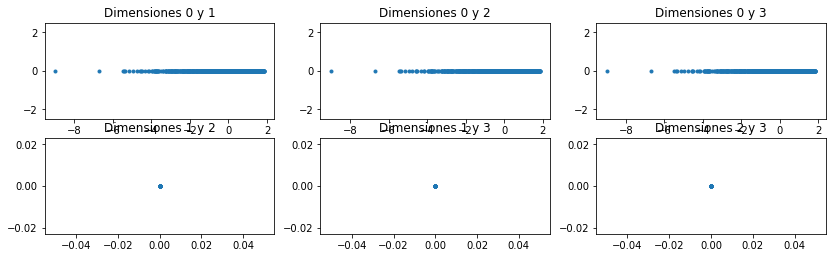

In [ ]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(red_Xdrr_tr[:,n1],red_Xdrr_tr[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        ii += 1

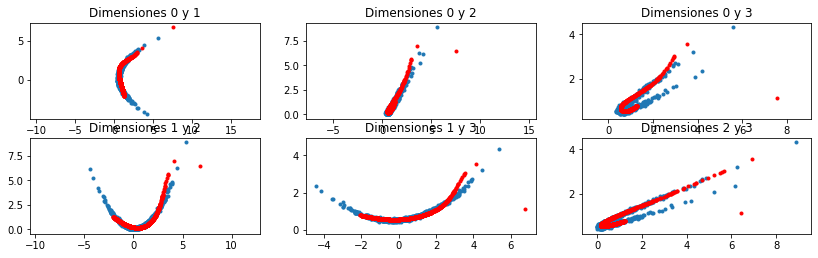

In [ ]:
# Mostramos las combinaciones de dimensiones 2 a 2
plt.figure(figsize=(14,6))
ii=1
for n1 in np.arange(0,d-1):
    for n2 in np.arange(n1+1,d):
        plt.subplot(d-1,d-1,ii), plt.plot(Xtr[:,n1],Xtr[:,n2],'.'), plt.axis('equal'), plt.title('Dimensiones ' + np.str(n1) + ' y ' + np.str(n2))
        plt.plot(inv_red_Xdrr_tr[:,n1],inv_red_Xdrr_tr[:,n2],'r.')
        ii += 1